<a href="https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Data_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data structures

In this notebook, we will explore some of the major data structures used in SLEAP and how they can be manipulated when generating predictions from trained models.

A quick overview of the data structures before we start:

- `Point`/`PredictedPoint` → Contains the `x` and `y` coordinates (and `score` for predictions) of a landmark.
- `Instance`/`PredictedInstance` → Contains a set of `Point`/`PredictedPoint`s. This represent a single individual within a frame and may also contain an associated `Track`.
- `Skeleton` → Defines the nodes and edges that define the set of unique landmark types that each point represents, e.g., "head", "tail", etc. This *does not contain positions* -- those are stored in individual `Point`s.
- `LabeledFrame` → Contains a set of `Instance`/`PredictedInstance`s for a single frame.
- `Labels` → Contains a set of `LabeledFrame`s and the associated metadata for the videos and other information related to the project or predictions.

## 1. Setup SLEAP and data

We'll start by installing SLEAP and downloading some data and models to play around with.

If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.

In [1]:
# This should take care of all the dependencies on colab:
!pip uninstall -qqq -y opencv-python opencv-contrib-python
!pip install -qqq "sleap[pypi]>=1.3.3"

# But to do it locally, we'd recommend the conda package (available on Windows + Linux):
# conda create -n sleap -c sleap -c conda-forge -c nvidia sleap

In [4]:
# Test video:
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4

# Test video labels (from predictions/not necessary for inference benchmarking):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp

# Bottom-up model:
# !wget https://storage.googleapis.com/sleap-data/reference/flies13/bu.210506_230852.multi_instance.n%3D1800.zip

# Top-down model (two-stage):
!wget https://storage.googleapis.com/sleap-data/reference/flies13/centroid.fast.210504_182918.centroid.n%3D1800.zip
!wget https://storage.googleapis.com/sleap-data/reference/flies13/td_fast.210505_012601.centered_instance.n%3D1800.zip

--2023-08-31 12:03:50--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.176.16, 142.250.72.144, 172.217.12.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.176.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85343812 (81M) [video/mp4]
Saving to: ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4.1’

190719_090330_wt_18 100%[===================>]  81.39M  27.7MB/s    in 2.9s    

2023-08-31 12:03:53 (27.7 MB/s) - ‘190719_090330_wt_18159206_rig1.2@15000-17560.mp4.1’ saved [85343812/85343812]

--2023-08-31 12:03:53--  https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.slp
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.240, 142.250.217.144, 142.250.68.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|1

In [5]:
!ls -lah

total 239M
drwxrwxr-x 3 talmolab talmolab 4.0K Aug 31 12:03  .
drwxrwxr-x 7 talmolab talmolab 4.0K Aug 31 11:39  ..
-rw-rw-r-- 1 talmolab talmolab  82M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.mp4
-rw-rw-r-- 1 talmolab talmolab  82M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.mp4.1
-rw-rw-r-- 1 talmolab talmolab 1.6M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.slp
-rw-rw-r-- 1 talmolab talmolab 1.6M May 20  2021  190719_090330_wt_18159206_rig1.2@15000-17560.slp.1
drwxrwxr-x 2 talmolab talmolab 4.0K Jun 20 10:00  analysis_example
-rw-rw-r-- 1 talmolab talmolab 713K Jun 20 10:00  Analysis_examples.ipynb
-rw-rw-r-- 1 talmolab talmolab 6.1M May 20  2021 'centroid.fast.210504_182918.centroid.n=1800.zip'
-rw-rw-r-- 1 talmolab talmolab 6.1M May 20  2021 'centroid.fast.210504_182918.centroid.n=1800.zip.1'
-rw-rw-r-- 1 talmolab talmolab 486K Aug 31 11:39  Data_structures.ipynb
-rw-rw-r-- 1 talmolab talmolab 4.1K Jun 20 10:00  index.rst
-rw-rw-r-- 

In [6]:
import sleap

# This prevents TensorFlow from allocating all the GPU memory, which leads to issues on
# some GPUs/platforms:
sleap.disable_preallocation()

# This would hide GPUs from the TensorFlow altogether:
# sleap.use_cpu_only()

# Print some info:
sleap.versions()
sleap.system_summary()

2023-08-31 12:03:56.989133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 12:03:57.058048: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 12:03:57.060007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../

SLEAP: 1.3.2
TensorFlow: 2.11.0
Numpy: 1.21.6
Python: 3.7.12
OS: Linux-5.15.0-78-generic-x86_64-with-debian-bookworm-sid
GPUs: None detected.


2023-08-31 12:03:58.223182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-31 12:03:58.223923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../lib64:
2023-08-31 12:03:58.223968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/talmolab/micromamba/envs/sleap_jupyter/lib/python3.7/site-packages/cv2/../../lib64:
2023-08-31 12:03:58.223999: W tensorflow/compiler/xla/stream_executor

## 2. Data structures and inference

SLEAP can read videos in a variety of different formats through the `sleap.load_video` high level API. Once loaded, the `sleap.Video` object allows you to access individual frames as if the it were a standard numpy array.

**Note:** The actual frames are not loaded until you access them so we don't blow up our memory when using long videos.

In [7]:
# Videos can be represented agnostic to the backend format
video = sleap.load_video("190719_090330_wt_18159206_rig1.2@15000-17560.mp4")

# sleap.Video objects have a numpy-like interface:
print(video.shape)

# And we can load images in the video using array indexing:
imgs = video[:4]
print(imgs.shape, imgs.dtype)

(2560, 1024, 1024, 1)
(4, 1024, 1024, 1) uint8


The high level interface for loading models (`sleap.load_model()`) takes model folders or zipped folders as input. These are outputs from our training procedure and need to contain a `"best_model.h5"` and `"training_config.json"`.
 
`best_model.h5` is an HDF5-serialized tf.keras.Model that was checkpointed during
training. It includes the architecture as well as the weights, so they're standalone
and don't need SLEAP -- BUT they do not contain the inference methods.

`training_config.json` is a serialized `sleap.TrainingJobConfig` that contains metadata
like what channels of the model correspond to what landmarks and etc.

Top-down models have two stages: centroid and centered instance confidence maps, which we train and save out separately, so loading them together links them up into a single inference model.

In [8]:
# Top-down
predictor = sleap.load_model([
    "centroid.fast.210504_182918.centroid.n=1800.zip",
    "td_fast.210505_012601.centered_instance.n=1800.zip"
    ])

# Bottom-up
# predictor = sleap.load_model("bu.210506_230852.multi_instance.n=1800.zip")

2023-08-31 12:03:58.498908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The high level predictor creates all the SLEAP data structures after doing inference. For example:

In [9]:
labels = predictor.predict(video)
labels

Output()

2023-08-31 12:04:01.923466: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -45 } dim { size: -46 } dim { size: -47 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -15 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -15 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3600 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -15 } dim { size: -48 } dim { size: -49 } dim { size: 1 } } 

Labels(labeled_frames=2560, videos=1, skeletons=1, tracks=0)

Labels contain not just the predicted data, but all the other associated data structures and metadata:

In [10]:
labels.videos

[Video(backend=MediaVideo(filename='190719_090330_wt_18159206_rig1.2@15000-17560.mp4', grayscale=True, bgr=True, dataset='', input_format='channels_last'))]

In [11]:
labels.skeletons

[Skeleton(name='Skeleton-0', description='None', nodes=['head', 'thorax', 'abdomen', 'wingL', 'wingR', 'forelegL4', 'forelegR4', 'midlegL4', 'midlegR4', 'hindlegL4', 'hindlegR4', 'eyeL', 'eyeR'], edges=[('thorax', 'head'), ('thorax', 'abdomen'), ('thorax', 'wingL'), ('thorax', 'wingR'), ('thorax', 'forelegL4'), ('thorax', 'forelegR4'), ('thorax', 'midlegL4'), ('thorax', 'midlegR4'), ('thorax', 'hindlegL4'), ('thorax', 'hindlegR4'), ('head', 'eyeL'), ('head', 'eyeR')], symmetries=[('forelegL4', 'forelegR4'), ('wingL', 'wingR'), ('eyeL', 'eyeR'), ('midlegL4', 'midlegR4'), ('hindlegL4', 'hindlegR4')])]

Individual labeled frames are accessible through a list-like interface:

In [12]:
labeled_frame = labels[0]  # shortcut for labels.labeled_frames[0]
labeled_frame

LabeledFrame(video=MediaVideo('190719_090330_wt_18159206_rig1.2@15000-17560.mp4'), frame_idx=0, instances=2)

Convenient methods allow for easy inspection:

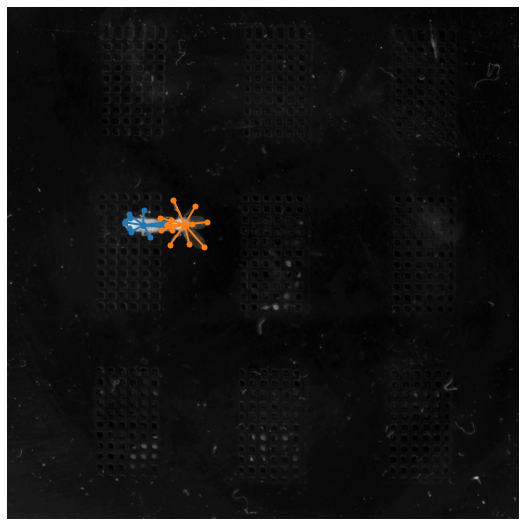

In [13]:
labels[0].plot(scale=0.5)

The labeled frame is itself a container for instances:

In [14]:
labeled_frame.instances

[PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (234.2, 430.5, 0.98), thorax: (271.6, 436.1, 0.94), abdomen: (308.0, 438.6, 0.59), wingL: (321.8, 440.1, 0.39), wingR: (322.0, 436.8, 0.49), forelegL4: (246.1, 450.6, 0.92), forelegR4: (242.3, 413.9, 0.78), midlegL4: (285.8, 459.9, 0.47), midlegR4: (272.3, 406.7, 0.77), hindlegR4: (317.6, 430.6, 0.30), eyeL: (242.1, 441.9, 0.89), eyeR: (245.3, 420.9, 0.92)], score=0.95, track=None, tracking_score=0.00),
 PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (319.4, 435.9, 0.83), thorax: (354.4, 435.2, 0.80), abdomen: (368.3, 433.8, 0.71), wingL: (393.9, 480.3, 0.83), wingR: (398.4, 430.0, 0.81), forelegL4: (307.8, 445.7, 0.26), forelegR4: (305.6, 421.4, 0.69), midlegL4: (325.7, 475.0, 0.94), midlegR4: (331.8, 38

In [15]:
instance = labeled_frame[0]  # shortcut for labeled_frame.instances[0]
instance

PredictedInstance(video=Video(filename=190719_090330_wt_18159206_rig1.2@15000-17560.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=0, points=[head: (234.2, 430.5, 0.98), thorax: (271.6, 436.1, 0.94), abdomen: (308.0, 438.6, 0.59), wingL: (321.8, 440.1, 0.39), wingR: (322.0, 436.8, 0.49), forelegL4: (246.1, 450.6, 0.92), forelegR4: (242.3, 413.9, 0.78), midlegL4: (285.8, 459.9, 0.47), midlegR4: (272.3, 406.7, 0.77), hindlegR4: (317.6, 430.6, 0.30), eyeL: (242.1, 441.9, 0.89), eyeR: (245.3, 420.9, 0.92)], score=0.95, track=None, tracking_score=0.00)

Finally, instances are containers for points:

In [16]:
instance.points

(PredictedPoint(x=234.24440002441406, y=430.52008056640625, visible=True, complete=False, score=0.9790770411491394),
 PredictedPoint(x=271.58941650390625, y=436.1461486816406, visible=True, complete=False, score=0.9358043670654297),
 PredictedPoint(x=308.02960205078125, y=438.57135009765625, visible=True, complete=False, score=0.5861632227897644),
 PredictedPoint(x=321.81768798828125, y=440.08721923828125, visible=True, complete=False, score=0.39127233624458313),
 PredictedPoint(x=322.0193176269531, y=436.7702941894531, visible=True, complete=False, score=0.48629727959632874),
 PredictedPoint(x=246.14295959472656, y=450.5621643066406, visible=True, complete=False, score=0.9176925420761108),
 PredictedPoint(x=242.2632598876953, y=413.9497375488281, visible=True, complete=False, score=0.780803382396698),
 PredictedPoint(x=285.78155517578125, y=459.91552734375, visible=True, complete=False, score=0.47393468022346497),
 PredictedPoint(x=272.280029296875, y=406.71759033203125, visible=True,

These can be converted into concrete arrays:

In [17]:
pts = instance.numpy()
print(pts)

[[234.24440002 430.52008057]
 [271.5894165  436.14614868]
 [308.02960205 438.5713501 ]
 [321.81768799 440.08721924]
 [322.01931763 436.77029419]
 [246.14295959 450.56216431]
 [242.26325989 413.94973755]
 [285.78155518 459.91552734]
 [272.2800293  406.71759033]
 [         nan          nan]
 [317.59887695 430.60534668]
 [242.10415649 441.94503784]
 [245.32009888 420.93606567]]


Images can be embedded together with the predictions in the same format:

In [18]:
labels = sleap.Labels(labels.labeled_frames[:4])  # crop to the first few labels for this example
labels.save("labels_with_images.pkg.slp", with_images=True, embed_all_labeled=True)

Let's delete the source data:

In [19]:
!rm "190719_090330_wt_18159206_rig1.2@15000-17560.mp4"

And check out what happens when we load in some labels with embedded images:

In [20]:
labels = sleap.load_file("labels_with_images.pkg.slp")
labels

Labels(labeled_frames=4, videos=1, skeletons=1, tracks=0)

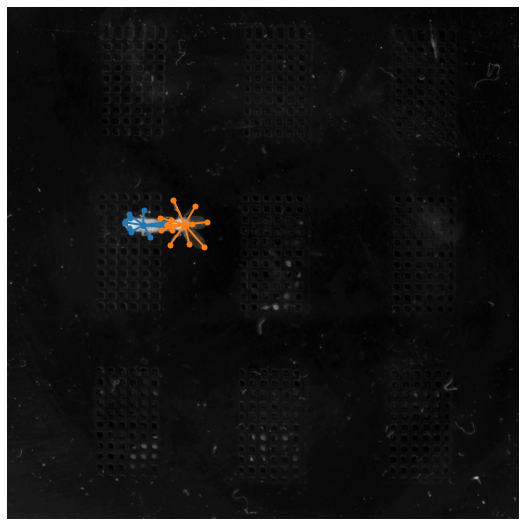

In [21]:
labels[0].plot(scale=0.5)